# Analysis of Pokémon Dataset
**Goal:** Predict the **Combat Power (Total)** of a Pokémon based on its features.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import os

sys.path.append(os.path.abspath(os.path.join('..')))

from src.regression_tree import RegressionTree
from src.random_forest import RandomForest
from src.utils import evaluate_model

# Set plot style
sns.set_theme(style="whitegrid")
%matplotlib inline

In [2]:
# Load the dataset
file_path = os.path.join('..', 'data', 'pokemon.csv')
df_raw = pd.read_csv(file_path)

print(f"Original Shape: {df_raw.shape}")
df_raw.head()

Original Shape: (151, 12)


,Name,Type 1,Type 2,Combat Power,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False
4,Charmeleon,Fire,NaN,405,58,64,58,80,65,80,1,False


## Preprocessing

In [3]:
def preprocess_pokemon(df):
    df = df.copy()
    
    # Drop non-predictive columns
    df = df.drop(columns=['#', 'Name'], errors='ignore')
    
    # Handle Missing Values
    if 'Type 2' in df.columns:
        df['Type 2'] = df['Type 2'].fillna('None')
    
    #Handle Categoricals
    cols_to_encode = ['Type 1', 'Type 2']
    existing_cols = [c for c in cols_to_encode if c in df.columns]
    
    df = pd.get_dummies(df, columns=existing_cols, drop_first=True, dtype=int)
    
    # Handle Booleans
    if 'Legendary' in df.columns:
        df['Legendary'] = df['Legendary'].astype(int)
        
    return df

# 4. Apply and Inspect
df_clean = preprocess_pokemon(df_raw)

print("Original Shape:", df_raw.shape)
print("Cleaned Shape: ", df_clean.shape)
print("\nFirst 5 rows of cleaned data:")
display(df_clean.head())

Original Shape: (151, 12)
Cleaned Shape:  (151, 34)

First 5 rows of cleaned data:


,Combat Power,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,Type 1_Dragon,...,Type 2_Flying,Type 2_Grass,Type 2_Ground,Type 2_Ice,Type 2_None,Type 2_Poison,Type 2_Psychic,Type 2_Rock,Type 2_Steel,Type 2_Water
0,318,45,49,49,65,65,45,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1,405,60,62,63,80,80,60,1,0,0,...,0,0,0,0,0,1,0,0,0,0
2,525,80,82,83,100,100,80,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,309,39,52,43,60,50,65,1,0,0,...,0,0,0,0,1,0,0,0,0,0
4,405,58,64,58,80,65,80,1,0,0,...,0,0,0,0,1,0,0,0,0,0


## Data Split


In [4]:
target_col = 'Combat Power'

X = df_clean.drop(columns=[target_col]).values

y = df_clean[target_col].values

print(f"Feature Matrix X shape: {X.shape}")
print(f"Target Vector y shape:  {y.shape}")

Feature Matrix X shape: (151, 33)
Target Vector y shape:  (151,)


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

print(f"Training Samples: {X_train.shape[0]}")
print(f"Test Samples:     {X_test.shape[0]} (Locked away)")

Training Samples: 120
Test Samples:     31 (Locked away)


## Training and Evaluation

--- REGRESSION TREE ---
  CV MSE (Error):    3865.7021
  CV R² (Stability):    0.5624
  Test MSE (Error):     2125.9586
  Test RMSE (Error):    46.1081
  Test R² (Accuracy):   0.8011
------------------------------
--- RANDOM FOREST ---
  CV MSE (Error):    1567.9633
  CV R² (Stability):    0.8197
  Test MSE (Error):     1239.9984
  Test RMSE (Error):    35.2136
  Test R² (Accuracy):   0.8840
------------------------------


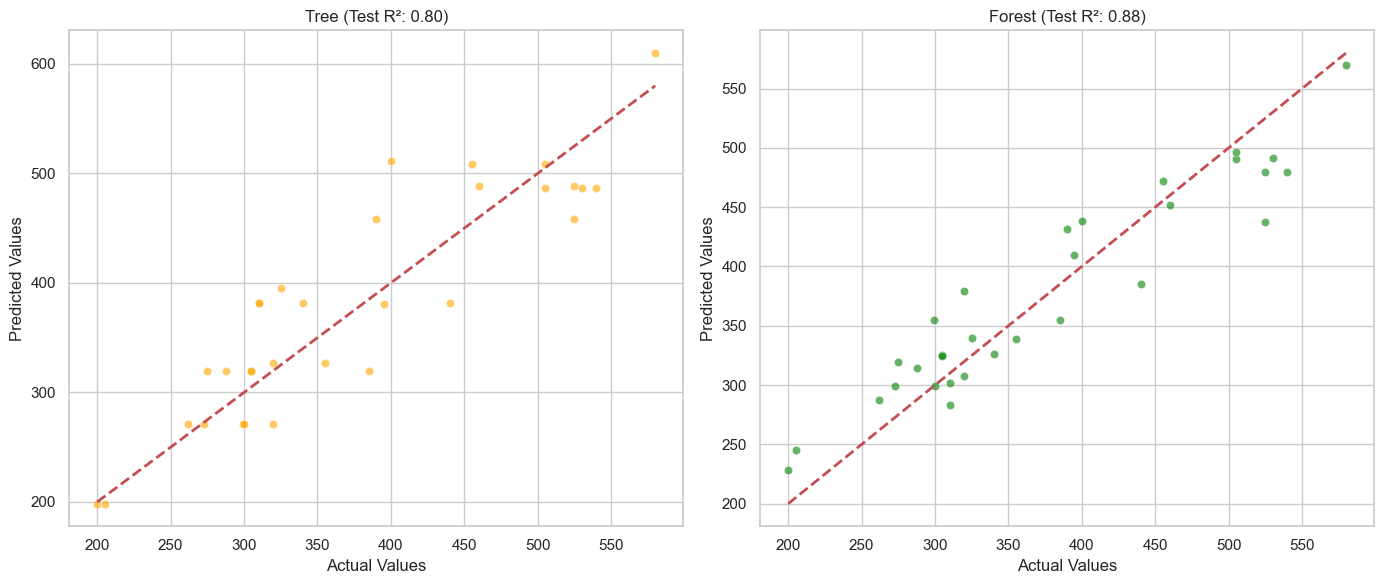

In [6]:
from src.regression_tree import RegressionTree
from src.random_forest import RandomForest
from src.utils import evaluate_model
from src.utils import print_results
import matplotlib.pyplot as plt
import seaborn as sns

# 1. EVALUATE REGRESSION TREE
# (Assuming your class uses 'min_samples_split' and 'max_depth')
tree_model = RegressionTree(min_samples_split=10, max_depth=5)
tree_results = evaluate_model(tree_model, X_train, y_train, X_test, y_test)
print_results("REGRESSION TREE", tree_results)

# 2. EVALUATE RANDOM FOREST
# (Note: Using 'seed' as per your previous message)
rf_model = RandomForest(n_trees=20, max_depth=5, seed=123)
rf_results = evaluate_model(rf_model, X_train, y_train, X_test, y_test)
print_results("RANDOM FOREST", rf_results)

# 3. VISUAL COMPARISON
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot Tree Results
sns.scatterplot(x=tree_results['y_test_actual'], y=tree_results['y_test_pred'], ax=axes[0], color='orange', alpha=0.6)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_title(f"Tree (Test R²: {tree_results['Test_R2']:.2f})")
axes[0].set_xlabel("Actual Values")
axes[0].set_ylabel("Predicted Values")

# Plot Forest Results
sns.scatterplot(x=rf_results['y_test_actual'], y=rf_results['y_test_pred'], ax=axes[1], color='green', alpha=0.6)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_title(f"Forest (Test R²: {rf_results['Test_R2']:.2f})")
axes[1].set_xlabel("Actual Values")
axes[1].set_ylabel("Predicted Values")

plt.tight_layout()
plt.show()